Loading the dataset and preparing pytorch tensors

FNN model

Using device: cuda
Epoch 1/100, Loss: 0.6426, Precision: 0.6571, Recall: 0.5243, F1 Score: 0.5832, Accuracy: 0.6253
Epoch 2/100, Loss: 0.5562, Precision: 0.8213, Recall: 0.4606, F1 Score: 0.5902, Accuracy: 0.6802
Epoch 3/100, Loss: 0.5217, Precision: 0.8565, Recall: 0.5012, F1 Score: 0.6323, Accuracy: 0.7085
Epoch 4/100, Loss: 0.4775, Precision: 0.8181, Recall: 0.6306, F1 Score: 0.7122, Accuracy: 0.7452
Epoch 5/100, Loss: 0.4293, Precision: 0.8233, Recall: 0.7621, F1 Score: 0.7915, Accuracy: 0.7992
Epoch 6/100, Loss: 0.3959, Precision: 0.8313, Recall: 0.8328, F1 Score: 0.8320, Accuracy: 0.8319
Epoch 7/100, Loss: 0.3764, Precision: 0.8384, Recall: 0.8528, F1 Score: 0.8455, Accuracy: 0.8442
Epoch 8/100, Loss: 0.3599, Precision: 0.8470, Recall: 0.8785, F1 Score: 0.8624, Accuracy: 0.8599
Epoch 9/100, Loss: 0.3401, Precision: 0.8606, Recall: 0.8867, F1 Score: 0.8735, Accuracy: 0.8715
Epoch 10/100, Loss: 0.3304, Precision: 0.8691, Recall: 0.8921, F1 Score: 0.8805, Accuracy: 0.8789
Epoch 11/1

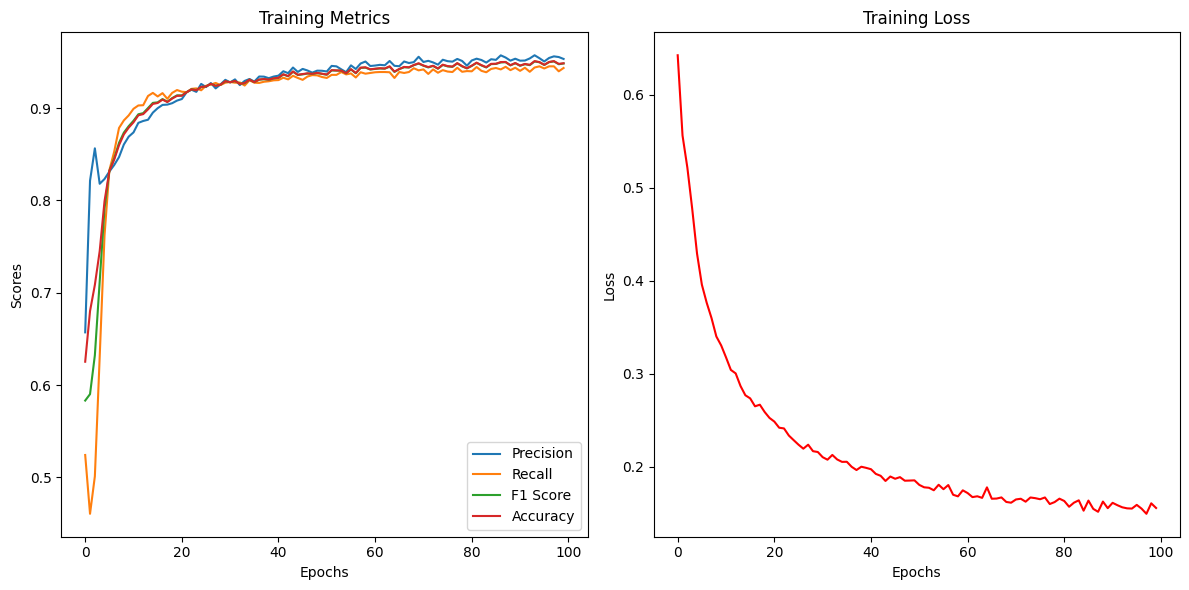

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9495    0.9661    0.9578       974
         1.0     0.9655    0.9486    0.9570       973

    accuracy                         0.9574      1947
   macro avg     0.9575    0.9574    0.9574      1947
weighted avg     0.9575    0.9574    0.9574      1947



In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('data/train_dataset.csv')
test_data = pd.read_csv('data/test_dataset.csv')

# Separate features and target
X_train = train_data.drop('Interaction', axis=1).values
y_train = train_data['Interaction'].values
X_test = test_data.drop('Interaction', axis=1).values
y_test = test_data['Interaction'].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the model
class DrugInteractionModel(nn.Module):
    def __init__(self, input_size):
        super(DrugInteractionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Input to hidden layer
        self.fc2 = nn.Linear(64, 32)         # Hidden to hidden layer
        self.fc3 = nn.Linear(32, 1)          # Hidden to output layer
        self.dropout = nn.Dropout(0.3)      # Dropout for regularization

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))      # Sigmoid for binary classification
        return x

# Initialize the model
input_size = X_train.shape[1]  # Number of features
model = DrugInteractionModel(input_size).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
train_losses = []
train_precisions = []
train_recalls = []
train_f1_scores = []
train_accuracies = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect predictions and labels for metrics
        predictions = (outputs > 0.5).float()  # Threshold at 0.5
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)

    train_losses.append(total_loss / len(train_loader))
    train_precisions.append(precision)
    train_recalls.append(recall)
    train_f1_scores.append(f1)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Plotting the Precision, Recall, F1 Score, Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_precisions, label='Precision')
plt.plot(range(epochs), train_recalls, label='Recall')
plt.plot(range(epochs), train_f1_scores, label='F1 Score')
plt.plot(range(epochs), train_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend()
plt.title('Training Metrics')

# Plotting the Cross-Entropy Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.tight_layout()
plt.show()

# Evaluate the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        predictions = (outputs > 0.5).float()  # Threshold at 0.5
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))


#CNN model

Using device: cuda
Epoch 1/100, Loss: 0.6382, Precision: 0.6290, Recall: 0.5669, F1 Score: 0.5963, Accuracy: 0.6162
Epoch 2/100, Loss: 0.4835, Precision: 0.8044, Recall: 0.6717, F1 Score: 0.7321, Accuracy: 0.7541
Epoch 3/100, Loss: 0.3740, Precision: 0.8441, Recall: 0.8359, F1 Score: 0.8400, Accuracy: 0.8407
Epoch 4/100, Loss: 0.3268, Precision: 0.8736, Recall: 0.8772, F1 Score: 0.8754, Accuracy: 0.8751
Epoch 5/100, Loss: 0.3044, Precision: 0.8875, Recall: 0.8939, F1 Score: 0.8907, Accuracy: 0.8903
Epoch 6/100, Loss: 0.2905, Precision: 0.8990, Recall: 0.9052, F1 Score: 0.9021, Accuracy: 0.9017
Epoch 7/100, Loss: 0.2693, Precision: 0.9075, Recall: 0.9068, F1 Score: 0.9071, Accuracy: 0.9071
Epoch 8/100, Loss: 0.2661, Precision: 0.9088, Recall: 0.9057, F1 Score: 0.9072, Accuracy: 0.9074
Epoch 9/100, Loss: 0.2544, Precision: 0.9120, Recall: 0.9104, F1 Score: 0.9112, Accuracy: 0.9112
Epoch 10/100, Loss: 0.2518, Precision: 0.9163, Recall: 0.9109, F1 Score: 0.9136, Accuracy: 0.9138
Epoch 11/1

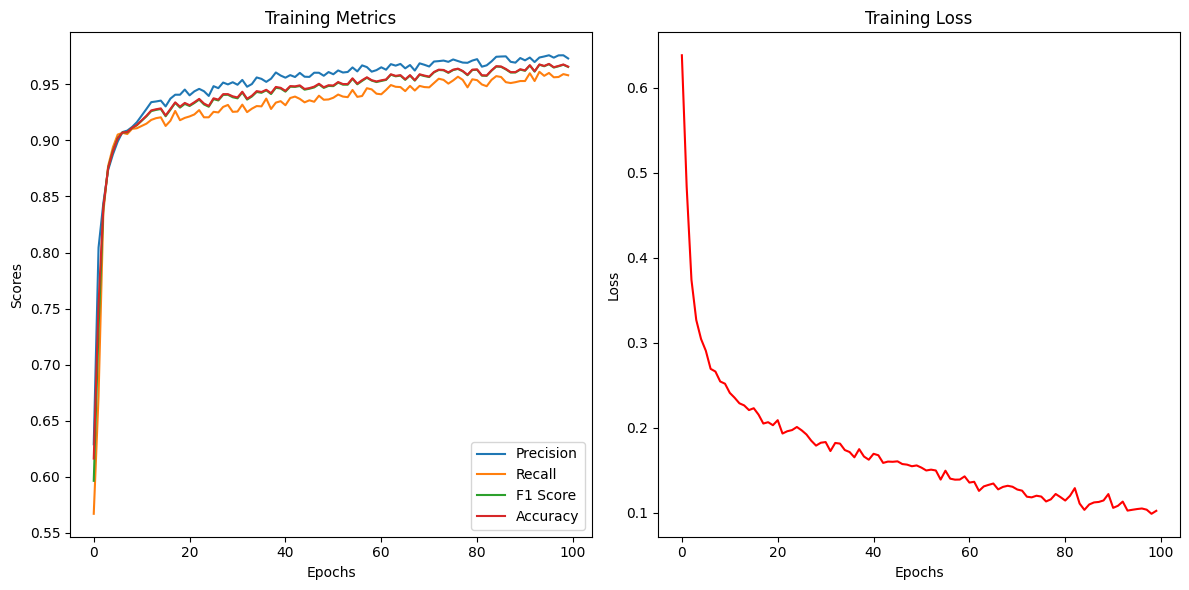

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9413    0.9548    0.9480       974
         1.0     0.9541    0.9404    0.9472       973

    accuracy                         0.9476      1947
   macro avg     0.9477    0.9476    0.9476      1947
weighted avg     0.9477    0.9476    0.9476      1947



In [8]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('data/train_dataset.csv')
test_data = pd.read_csv('data/test_dataset.csv')

# Separate features and target
X_train = train_data.drop('Interaction', axis=1).values
y_train = train_data['Interaction'].values
X_test = test_data.drop('Interaction', axis=1).values
y_test = test_data['Interaction'].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the CNN model
class CNNDrugInteractionModel(nn.Module):
    def __init__(self, input_size):
        super(CNNDrugInteractionModel, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)  # First Conv Layer
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Second Conv Layer
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * (input_size // 4), 64)  # Adjusting input size for the flattened output
        self.fc2 = nn.Linear(64, 1)    # Output layer
        self.dropout = nn.Dropout(0.3) # Dropout for regularization

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1d [batch_size, 1, num_features]
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2)  # Max pooling
        
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2)  # Max pooling
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Flatten the tensor before feeding to fully connected layers
        
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x



# Initialize the CNN model
input_size = X_train.shape[1]  # Number of features
model = CNNDrugInteractionModel(input_size).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
train_losses = []
train_precisions = []
train_recalls = []
train_f1_scores = []
train_accuracies = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect predictions and labels for metrics
        predictions = (outputs > 0.5).float()  # Threshold at 0.5
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)

    train_losses.append(total_loss / len(train_loader))
    train_precisions.append(precision)
    train_recalls.append(recall)
    train_f1_scores.append(f1)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Plotting the Precision, Recall, F1 Score, Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_precisions, label='Precision')
plt.plot(range(epochs), train_recalls, label='Recall')
plt.plot(range(epochs), train_f1_scores, label='F1 Score')
plt.plot(range(epochs), train_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend()
plt.title('Training Metrics')

# Plotting the Cross-Entropy Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.tight_layout()
plt.show()

# Evaluate the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        predictions = (outputs > 0.5).float()  # Threshold at 0.5
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))


RNN model

Using device: cuda
Epoch 1/100, Loss: 0.6652, Precision: 0.6092, Recall: 0.6049, F1 Score: 0.6070, Accuracy: 0.6083
Epoch 2/100, Loss: 0.6527, Precision: 0.6319, Recall: 0.5931, F1 Score: 0.6119, Accuracy: 0.6238
Epoch 3/100, Loss: 0.6520, Precision: 0.6478, Recall: 0.5911, F1 Score: 0.6181, Accuracy: 0.6348
Epoch 4/100, Loss: 0.6521, Precision: 0.6350, Recall: 0.6144, F1 Score: 0.6245, Accuracy: 0.6306
Epoch 5/100, Loss: 0.6525, Precision: 0.6497, Recall: 0.5826, F1 Score: 0.6143, Accuracy: 0.6342
Epoch 6/100, Loss: 0.6515, Precision: 0.6508, Recall: 0.5952, F1 Score: 0.6218, Accuracy: 0.6379
Epoch 7/100, Loss: 0.6521, Precision: 0.6436, Recall: 0.5959, F1 Score: 0.6188, Accuracy: 0.6329
Epoch 8/100, Loss: 0.6512, Precision: 0.6518, Recall: 0.5967, F1 Score: 0.6230, Accuracy: 0.6389
Epoch 9/100, Loss: 0.6511, Precision: 0.6425, Recall: 0.5931, F1 Score: 0.6168, Accuracy: 0.6315
Epoch 10/100, Loss: 0.6512, Precision: 0.6576, Recall: 0.5718, F1 Score: 0.6117, Accuracy: 0.6370
Epoch 11/1

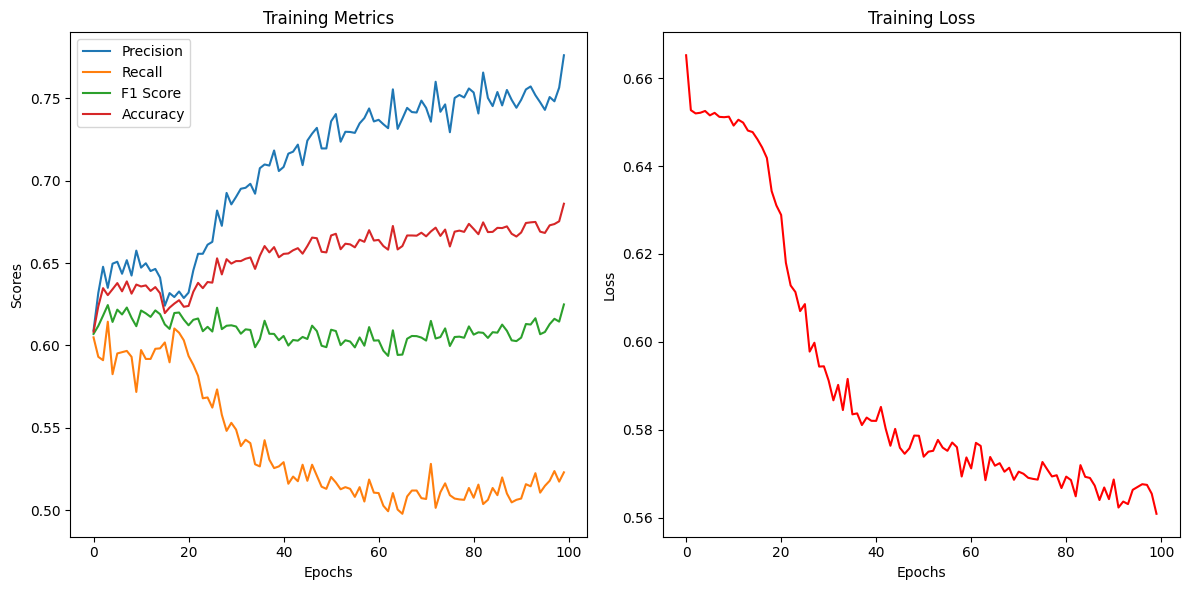

Classification Report:
               precision    recall  f1-score   support

         0.0     0.6335    0.9815    0.7700       974
         1.0     0.9589    0.4317    0.5953       973

    accuracy                         0.7067      1947
   macro avg     0.7962    0.7066    0.6827      1947
weighted avg     0.7961    0.7067    0.6827      1947



In [9]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('data/train_dataset.csv')
test_data = pd.read_csv('data/test_dataset.csv')

# Separate features and target
X_train = train_data.drop('Interaction', axis=1).values
y_train = train_data['Interaction'].values
X_test = test_data.drop('Interaction', axis=1).values
y_test = test_data['Interaction'].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Reshaping input to (batch_size, seq_length, input_size)
# Assuming we treat each feature as a time step for the RNN (you can adjust seq_length if needed)
X_train_tensor = X_train_tensor.unsqueeze(1)  # Adding seq_length dimension (1 time step per feature)
X_test_tensor = X_test_tensor.unsqueeze(1)    # Adding seq_length dimension (1 time step per feature)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the model (RNN-based)
class DrugInteractionRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(DrugInteractionRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x.shape: (batch_size, seq_length, input_size)
        rnn_out, _ = self.rnn(x)  # RNN outputs
        last_rnn_out = rnn_out[:, -1, :]  # Get the output of the last time step
        x = self.dropout(last_rnn_out)
        x = torch.sigmoid(self.fc(x))  # Sigmoid for binary classification
        return x

# Initialize the model
input_size = X_train.shape[1]  # Number of features
hidden_size = 64  # RNN hidden layer size
model = DrugInteractionRNNModel(input_size, hidden_size).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
train_losses = []
train_precisions = []
train_recalls = []
train_f1_scores = []
train_accuracies = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect predictions and labels for metrics
        predictions = (outputs > 0.5).float()  # Threshold at 0.5
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)

    train_losses.append(total_loss / len(train_loader))
    train_precisions.append(precision)
    train_recalls.append(recall)
    train_f1_scores.append(f1)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Plotting the Precision, Recall, F1 Score, Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_precisions, label='Precision')
plt.plot(range(epochs), train_recalls, label='Recall')
plt.plot(range(epochs), train_f1_scores, label='F1 Score')
plt.plot(range(epochs), train_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend()
plt.title('Training Metrics')

# Plotting the Cross-Entropy Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.tight_layout()
plt.show()

# Evaluate the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        predictions = (outputs > 0.5).float()  # Threshold at 0.5
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))


XGBoost Model

d:\Drug Interaction venv\Interaction\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0     0.7838    0.9415    0.8554       974
           1     0.9266    0.7400    0.8229       973

    accuracy                         0.8408      1947
   macro avg     0.8552    0.8407    0.8391      1947
weighted avg     0.8552    0.8408    0.8391      1947

Accuracy: 0.8408


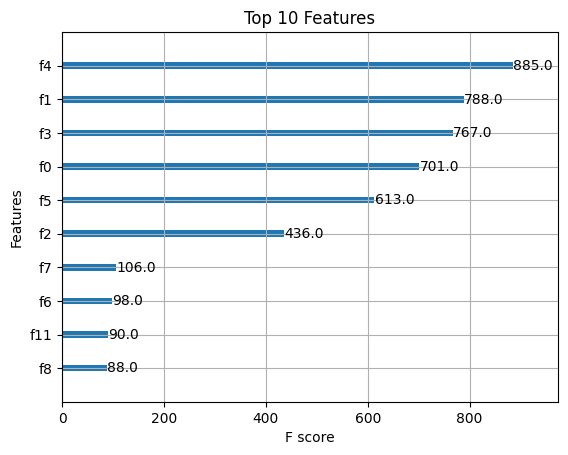

In [10]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('data/train_dataset.csv')
test_data = pd.read_csv('data/test_dataset.csv')

# Separate features and target
X_train = train_data.drop('Interaction', axis=1).values
y_train = train_data['Interaction'].values
X_test = test_data.drop('Interaction', axis=1).values
y_test = test_data['Interaction'].values

# Convert to DMatrix (XGBoost specific format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',        # Evaluation metric
    'max_depth': 6,                  # Max depth of trees
    'learning_rate': 0.01,           # Learning rate
    'silent': 1,                     # Silent mode
    'colsample_bytree': 0.8,         # Fraction of features to consider for each tree
    'subsample': 0.8,                # Fraction of data used per tree
    'n_estimators': 100              # Number of trees (boosting rounds)
}

# Train the model
num_round = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

# Predict on the test set
y_pred_proba = bst.predict(dtest)  # Predicted probabilities

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Feature importance plot
xgb.plot_importance(bst, importance_type='weight', max_num_features=10, title='Top 10 Features')
plt.show()


Random Forest Model

Classification Report:
               precision    recall  f1-score   support

           0     0.9250    0.9630    0.9437       974
           1     0.9614    0.9219    0.9412       973

    accuracy                         0.9425      1947
   macro avg     0.9432    0.9425    0.9425      1947
weighted avg     0.9432    0.9425    0.9425      1947



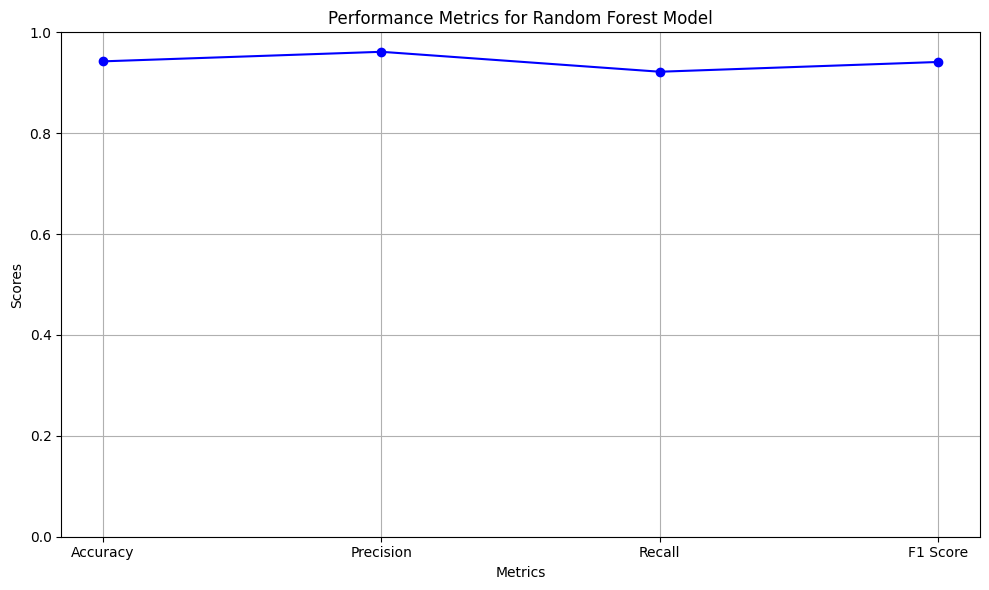

Confusion Matrix:
[[938  36]
 [ 76 897]]


In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('data/train_dataset.csv')
test_data = pd.read_csv('data/test_dataset.csv')

# Separate features and target
X_train = train_data.drop('Interaction', axis=1).values
y_train = train_data['Interaction'].values
X_test = test_data.drop('Interaction', axis=1).values
y_test = test_data['Interaction'].values

# Initialize Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
accuracy = accuracy_score(y_test, y_pred)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# Accuracy, Precision, Recall, F1 score for plotting
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

# Prepare data for line plot
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Plotting the metrics as a line graph
plt.figure(figsize=(10, 6))
plt.plot(metric_names, metric_values, marker='o', linestyle='-', color='b', label='Metrics')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics for Random Forest Model')
plt.ylim(0, 1)  # Limiting the Y-axis to between 0 and 1 for clarity
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


MLP Model

Using device: cuda
Epoch 1/100, Loss: 0.6044, Precision: 0.7074, Recall: 0.5230, F1 Score: 0.6014, Accuracy: 0.6533
Epoch 2/100, Loss: 0.5350, Precision: 0.8828, Recall: 0.4606, F1 Score: 0.6053, Accuracy: 0.6997
Epoch 3/100, Loss: 0.4518, Precision: 0.8279, Recall: 0.6894, F1 Score: 0.7523, Accuracy: 0.7730
Epoch 4/100, Loss: 0.3550, Precision: 0.8510, Recall: 0.8585, F1 Score: 0.8547, Accuracy: 0.8541
Epoch 5/100, Loss: 0.3206, Precision: 0.8708, Recall: 0.8934, F1 Score: 0.8820, Accuracy: 0.8804
Epoch 6/100, Loss: 0.2988, Precision: 0.8804, Recall: 0.8962, F1 Score: 0.8882, Accuracy: 0.8872
Epoch 7/100, Loss: 0.2772, Precision: 0.8974, Recall: 0.9073, F1 Score: 0.9023, Accuracy: 0.9017
Epoch 8/100, Loss: 0.2602, Precision: 0.9048, Recall: 0.9132, F1 Score: 0.9090, Accuracy: 0.9085
Epoch 9/100, Loss: 0.2502, Precision: 0.9084, Recall: 0.9145, F1 Score: 0.9114, Accuracy: 0.9111
Epoch 10/100, Loss: 0.2369, Precision: 0.9165, Recall: 0.9165, F1 Score: 0.9165, Accuracy: 0.9165
Epoch 11/1

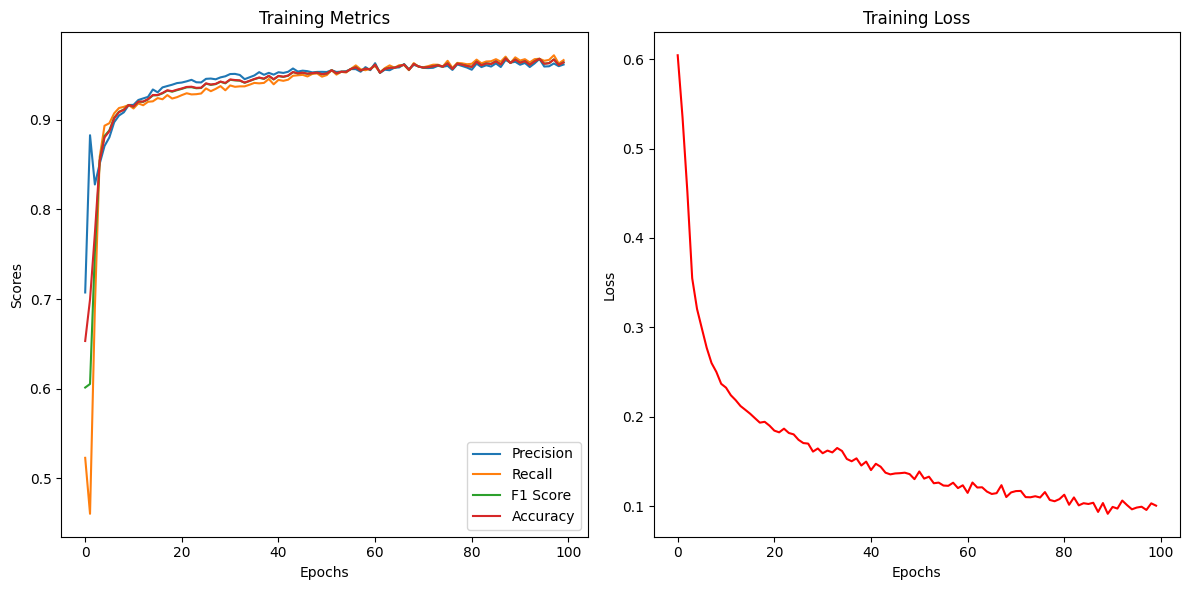

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9652    0.9692    0.9672       974
         1.0     0.9690    0.9651    0.9670       973

    accuracy                         0.9671      1947
   macro avg     0.9671    0.9671    0.9671      1947
weighted avg     0.9671    0.9671    0.9671      1947



In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('data/train_dataset.csv')
test_data = pd.read_csv('data/test_dataset.csv')

# Separate features and target
X_train = train_data.drop('Interaction', axis=1).values
y_train = train_data['Interaction'].values
X_test = test_data.drop('Interaction', axis=1).values
y_test = test_data['Interaction'].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Input to hidden layer
        self.fc2 = nn.Linear(128, 64)         # Hidden to hidden layer
        self.fc3 = nn.Linear(64, 32)          # Hidden to hidden layer
        self.fc4 = nn.Linear(32, 1)           # Hidden to output layer
        self.dropout = nn.Dropout(0.3)        # Dropout for regularization

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))        # Sigmoid for binary classification
        return x

# Initialize the MLP model
model = MLPModel(input_size=X_train.shape[1]).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
train_losses = []
train_precisions = []
train_recalls = []
train_f1_scores = []
train_accuracies = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect predictions and labels for metrics
        predictions = (outputs > 0.5).float()  # Threshold at 0.5
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)

    train_losses.append(total_loss / len(train_loader))
    train_precisions.append(precision)
    train_recalls.append(recall)
    train_f1_scores.append(f1)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Plotting the Precision, Recall, F1 Score, Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_precisions, label='Precision')
plt.plot(range(epochs), train_recalls, label='Recall')
plt.plot(range(epochs), train_f1_scores, label='F1 Score')
plt.plot(range(epochs), train_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend()
plt.title('Training Metrics')

# Plotting the Cross-Entropy Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.tight_layout()
plt.show()

# Evaluate the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        predictions = (outputs > 0.5).float()  # Threshold at 0.5
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))


DNN model

Using device: cuda
Epoch 1/100, Loss: 0.5828, Precision: 0.8142, Recall: 0.4390, F1 Score: 0.5704, Accuracy: 0.6694
Epoch 2/100, Loss: 0.4894, Precision: 0.8503, Recall: 0.5674, F1 Score: 0.6806, Accuracy: 0.7337
Epoch 3/100, Loss: 0.3284, Precision: 0.8644, Recall: 0.8631, F1 Score: 0.8638, Accuracy: 0.8638
Epoch 4/100, Loss: 0.2764, Precision: 0.8988, Recall: 0.8895, F1 Score: 0.8941, Accuracy: 0.8947
Epoch 5/100, Loss: 0.2525, Precision: 0.9156, Recall: 0.9034, F1 Score: 0.9095, Accuracy: 0.9101
Epoch 6/100, Loss: 0.2386, Precision: 0.9150, Recall: 0.9070, F1 Score: 0.9110, Accuracy: 0.9114
Epoch 7/100, Loss: 0.2339, Precision: 0.9191, Recall: 0.9078, F1 Score: 0.9134, Accuracy: 0.9139
Epoch 8/100, Loss: 0.2230, Precision: 0.9281, Recall: 0.9116, F1 Score: 0.9198, Accuracy: 0.9205
Epoch 9/100, Loss: 0.2073, Precision: 0.9362, Recall: 0.9191, F1 Score: 0.9275, Accuracy: 0.9282
Epoch 10/100, Loss: 0.2092, Precision: 0.9307, Recall: 0.9175, F1 Score: 0.9241, Accuracy: 0.9246
Epoch 11/1

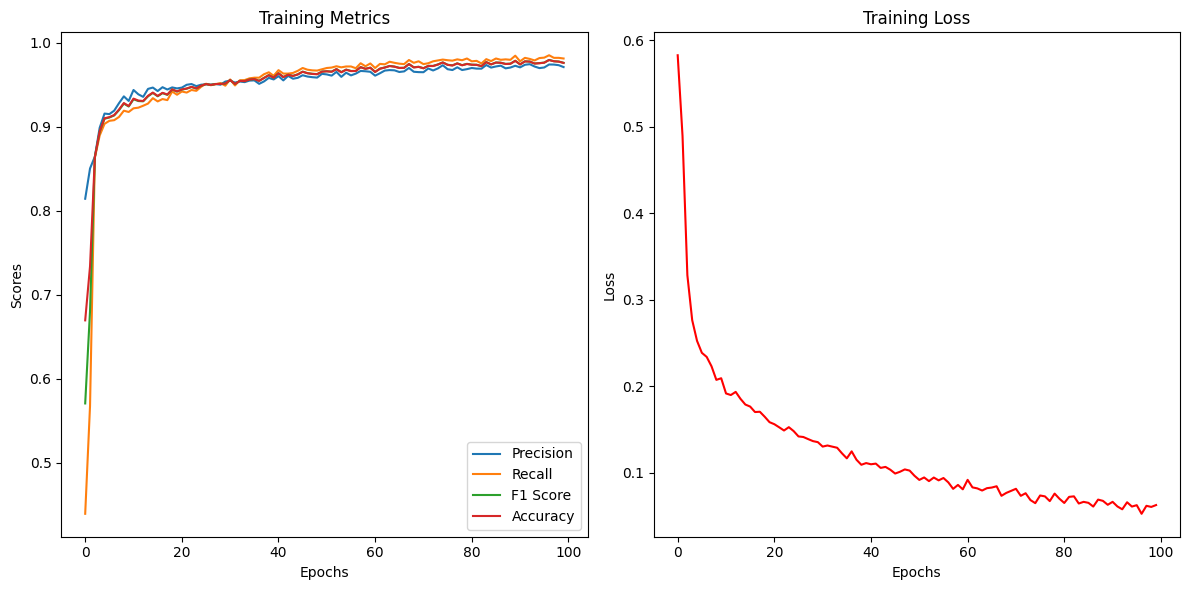

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9730    0.9610    0.9669       974
         1.0     0.9614    0.9733    0.9673       973

    accuracy                         0.9671      1947
   macro avg     0.9672    0.9671    0.9671      1947
weighted avg     0.9672    0.9671    0.9671      1947



In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('data/train_dataset.csv')
test_data = pd.read_csv('data/test_dataset.csv')

# Separate features and target
X_train = train_data.drop('Interaction', axis=1).values
y_train = train_data['Interaction'].values
X_test = test_data.drop('Interaction', axis=1).values
y_test = test_data['Interaction'].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define DNN Model
class DNNModel(nn.Module):
    def __init__(self, input_size):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Input to hidden layer
        self.fc2 = nn.Linear(256, 128)         # Hidden to hidden layer
        self.fc3 = nn.Linear(128, 64)          # Hidden to hidden layer
        self.fc4 = nn.Linear(64, 32)           # Hidden to hidden layer
        self.fc5 = nn.Linear(32, 1)            # Hidden to output layer
        self.dropout = nn.Dropout(0.3)         # Dropout for regularization

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))         # Sigmoid for binary classification
        return x

# Initialize the DNN model
model = DNNModel(input_size=X_train.shape[1]).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
train_losses = []
train_precisions = []
train_recalls = []
train_f1_scores = []
train_accuracies = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect predictions and labels for metrics
        predictions = (outputs > 0.5).float()  # Threshold at 0.5
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)

    train_losses.append(total_loss / len(train_loader))
    train_precisions.append(precision)
    train_recalls.append(recall)
    train_f1_scores.append(f1)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Plotting the Precision, Recall, F1 Score, Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_precisions, label='Precision')
plt.plot(range(epochs), train_recalls, label='Recall')
plt.plot(range(epochs), train_f1_scores, label='F1 Score')
plt.plot(range(epochs), train_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend()
plt.title('Training Metrics')

# Plotting the Cross-Entropy Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.tight_layout()
plt.show()

# Evaluate the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        predictions = (outputs > 0.5).float()  # Threshold at 0.5
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))
